In [ ]:
import os
import time
from dataclasses import dataclass
from typing import List, Union, Tuple
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Tuple
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import datasets, transforms
from torchvision import models as Predefined_Models
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy
# Text formatting
bold = "\033[1m"
end = "\033[0m"
plt.style.use('ggplot')
block_plot=False

%matplotlib inline

In [ ]:
def image_preprocess_transforms(img_size):
    preprocess = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    )

    return preprocess
def image_common_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms(img_size)

    common_transforms = transforms.Compose(
        [
            preprocess,
            transforms.Normalize(mean, std),
        ]
    )

    return common_transforms

def image_common_transforms_augmentation(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    common_transforms = transforms.Compose(
        [
        transforms.RandomResizedCrop(img_size[0], scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        ]
    )
    return common_transforms
def get_mean_std(data_root, img_size=(224, 224), num_workers=4):
    transform = image_preprocess_transforms(img_size=img_size)

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )

    return loader

In [6]:
def get_data(batch_size, data_root, img_size=(224, 224), num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, "Train")
    valid_data_path = os.path.join(data_root, "Valid")
    mean, std = get_mean_std(data_root=train_data_path, img_size=img_size, num_workers=num_workers)
    train_transforms = image_common_transforms(img_size, mean, std)
    valid_transforms = image_common_transforms(img_size, mean, std)
    if(data_augmentation):
        train_transforms = image_common_transforms_augmentation(img_size, mean, std)
    train_loader = data_loader(train_data_path,train_transforms,batch_size=batch_size,shuffle=True,num_workers=num_workers)
    valid_loader = data_loader(valid_data_path,valid_transforms,batch_size=batch_size,shuffle=False,num_workers=num_workers)
    return train_loader, valid_loader

In [7]:
@dataclass
class SystemConfig:
    """
    Describes the common system setting needed for reproducible training
    """

    seed: int = 21  # Seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # Enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # Make cudnn deterministic (reproducible training)

In [8]:
@dataclass
class TrainingConfig:
    """
    Describes configuration of the training process
    """

    num_classes: int = 3
    batch_size: int = 32
    img_size: Tuple = (224, 224)
    epochs_count: int = 100
    init_learning_rate: float = 2e-4  # Initial learning rate
    weight_decay : float = 1e-4
    data_root: str = "/kaggle/input/open-cv-py-torch-project-1-classification-round-2/dataset"
    num_workers: int = 2
    device: str = "cuda"
    patience : int = 15

    # For tensorboard logging and saving checkpoints
    save_model_name: str = "cat_dog_panda_classifier.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir: str = "version_0"
    checkpoint_dir: str = "version_0"

In [9]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [ ]:
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int,
) -> Tuple[float, float]:
    
    # Change model in training mode.
    model.train()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Train:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(train_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Batch Loss.
        mean_metric(loss.item(), weight=data.shape[0])

        # # Get probability score using softmax.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Train Loss: {mean_metric.compute():.4f}, Train Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    epoch_loss = mean_metric.compute()
    epoch_acc = acc_metric.compute()

    prog_bar.close()

    return epoch_loss, epoch_acc

def validate(
    train_config: TrainingConfig, 
    model: nn.Module, 
    valid_loader: torch.utils.data.DataLoader,
    epoch_idx: int, 
    total_epochs: int
) -> Tuple[float, float]:

    # Change model in evaluation mode.
    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Valid:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(valid_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        valid_loss = F.cross_entropy(output, target).item()

        # Batch validation loss.
        mean_metric(valid_loss, weight=data.shape[0])

        # # Convert model's logits to probability scores.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Valid Loss: {mean_metric.compute():.4f}, Valid Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    valid_loss = mean_metric.compute()
    valid_acc = acc_metric.compute()

    prog_bar.close()

    return valid_loss, valid_acc

In [12]:
def save_model(model, device, model_dir="models", model_file_name="cat_dog_panda_classifier.pt"):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # Make sure you transfer the model to cpu.
    if device == "cuda":
        model.to("cpu")

    # Save the 'state_dict'
    torch.save(model.state_dict(), model_path)
    
    if device == "cuda":
        model.to("cuda")

    return

In [13]:
def load_model(model, model_dir="models", model_file_name="cat_dog_panda_classifier.pt", device=torch.device("cpu")):
    model_path = os.path.join(model_dir, model_file_name)

    # Load model parameters by using 'load_state_dict'.
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

In [14]:
def setup_log_directory(training_config=TrainingConfig()):
    """Tensorboard Log and Model checkpoint directory Setup"""

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir.
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory.
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version.
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

    return training_config, version_name

In [15]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = min(train_loss[i])
        min_val_loss = min(val_loss[i])

        plt.plot(x_train, train_loss[i], linestyle="-", color=f"tab:{colors[i]}", label=f"TRAIN LOSS ({min_train_loss:.4})")
        plt.plot(x_val, val_loss[i], linestyle="--", color=f"tab:{colors[i]}", label=f"VALID LOSS ({min_val_loss:.4})")


    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training and Validation Loss")
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = max(train_acc[i])
        max_val_acc = max(val_acc[i])

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color=f"tab:{colors[i]}",
            label=f"TRAIN ACC ({max_train_acc:.4})",
        )

        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color=f"tab:{colors[i]}",
            label=f"VALID ACC ({max_val_acc:.4})",
        )


    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    fig.savefig("sample_loss_acc_plot.png")
    plt.show()

    return

In [16]:
def main(model, summary_writer, scheduler=None, system_config=SystemConfig(), training_config=TrainingConfig(), data_augmentation=True):
    
    # Setup system configuration.
    setup_system(system_config)

    # Initialize data loader
    train_loader, valid_loader = get_data(
        batch_size=training_config.batch_size,
        data_root=training_config.data_root,
        img_size=training_config.img_size,
        num_workers=training_config.num_workers,
        data_augmentation=data_augmentation,
    )

    # Number of epochs to train.
    NUM_EPOCHS = training_config.epochs_count

    # Set acceleration device.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Send model to device (GPU/CPU)
    model.to(device)

    # Initialize Adam optimizer.
    optimizer = torch.optim.Adam(model.parameters(), lr=training_config.init_learning_rate, weight_decay=training_config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    best_loss = torch.tensor(np.inf)

    # Epoch train & valid loss accumulator.
    epoch_train_loss = []
    epoch_valid_loss = []

    # Epoch train & valid accuracy accumulator.
    epoch_train_acc = []
    epoch_valid_acc = []

    # Trainig time measurement
    t_begin = time.time()
    counter = 0
    patience = training_config.patience
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(training_config, model, optimizer, train_loader, epoch + 1, NUM_EPOCHS)
        val_loss, val_accuracy = validate(training_config, model, valid_loader, epoch + 1, NUM_EPOCHS)

        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        epoch_valid_loss.append(val_loss)
        epoch_valid_acc.append(val_accuracy)

        summary_writer.add_scalar("Loss/Train", train_loss, epoch)
        summary_writer.add_scalar("Accuracy/Train", train_acc, epoch)

        summary_writer.add_scalar("Loss/Validation", val_loss, epoch)
        summary_writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            print(f"\nModel Improved... Saving Model ... ", end="")
            torch.save(model.state_dict(), os.path.join(training_config.checkpoint_dir, training_config.save_model_name))
            print("Done.\n")
        else:
            counter += 1

        scheduler.step()
        if epoch > 30 and counter > patience:
            print(f"⏹️ Early stopping triggered after {patience} epochs with no improvement.")
            break

        print(f"{'='*72}\n")

    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")

    return epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.base_model = Predefined_Models.resnet34()
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

In [19]:
model = MyModel(num_classes=3)
print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = SummaryWriter(training_config.log_dir)

MyModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [20]:
# Train and Validate
train_loss, train_acc, val_loss, val_acc = main(
    model,
    summary_writer=summary_writer,
    scheduler=None,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=True,
)

mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


Train:	Epoch: 1/100 Train Loss: 0.9898, Train Acc: 0.5138: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s]
Valid:	Epoch: 1/100 Valid Loss: 1.3445, Valid Acc: 0.5333: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 2/100 Train Loss: 0.8773, Train Acc: 0.5510: 100%|██████████| 66/66 [00:13<00:00,  4.85it/s]
Valid:	Epoch: 2/100 Valid Loss: 1.3169, Valid Acc: 0.5267: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 3/100 Train Loss: 0.8234, Train Acc: 0.5762: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s]
Valid:	Epoch: 3/100 Valid Loss: 0.7717, Valid Acc: 0.6267: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 4/100 Train Loss: 0.7695, Train Acc: 0.6000: 100%|██████████| 66/66 [00:13<00:00,  4.81it/s]
Valid:	Epoch: 4/100 Valid Loss: 0.8752, Valid Acc: 0.5600: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]


Train:	Epoch: 5/100 Train Loss: 0.7213, Train Acc: 0.6171: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s]
Valid:	Epoch: 5/100 Valid Loss: 0.6479, Valid Acc: 0.6467: 100%|██████████| 10/10 [00:01<00:00,  9.14it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 6/100 Train Loss: 0.6732, Train Acc: 0.6414: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s]
Valid:	Epoch: 6/100 Valid Loss: 0.6576, Valid Acc: 0.6900: 100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


Train:	Epoch: 7/100 Train Loss: 0.6594, Train Acc: 0.6567: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s]
Valid:	Epoch: 7/100 Valid Loss: 0.6102, Valid Acc: 0.6833: 100%|██████████| 10/10 [00:01<00:00,  9.11it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 8/100 Train Loss: 0.6579, Train Acc: 0.6548: 100%|██████████| 66/66 [00:13<00:00,  4.81it/s]
Valid:	Epoch: 8/100 Valid Loss: 0.6833, Valid Acc: 0.6267: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


Train:	Epoch: 9/100 Train Loss: 0.6509, Train Acc: 0.6538: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s]
Valid:	Epoch: 9/100 Valid Loss: 0.7854, Valid Acc: 0.6600: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


Train:	Epoch: 10/100 Train Loss: 0.6056, Train Acc: 0.6886: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s]
Valid:	Epoch: 10/100 Valid Loss: 0.6542, Valid Acc: 0.6867: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


Train:	Epoch: 11/100 Train Loss: 0.6000, Train Acc: 0.6943: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s]
Valid:	Epoch: 11/100 Valid Loss: 0.6120, Valid Acc: 0.6967: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Train:	Epoch: 12/100 Train Loss: 0.6110, Train Acc: 0.7024: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s]
Valid:	Epoch: 12/100 Valid Loss: 0.5454, Valid Acc: 0.7267: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 13/100 Train Loss: 0.5899, Train Acc: 0.7090: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s]
Valid:	Epoch: 13/100 Valid Loss: 0.8964, Valid Acc: 0.6467: 100%|██████████| 10/10 [00:01<00:00,  9.31it/s]


Train:	Epoch: 14/100 Train Loss: 0.5706, Train Acc: 0.7238: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s]
Valid:	Epoch: 14/100 Valid Loss: 0.6762, Valid Acc: 0.6833: 100%|██████████| 10/10 [00:01<00:00,  9.61it/s]


Train:	Epoch: 15/100 Train Loss: 0.5413, Train Acc: 0.7524: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s]
Valid:	Epoch: 15/100 Valid Loss: 0.7403, Valid Acc: 0.6867: 100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Train:	Epoch: 16/100 Train Loss: 0.5239, Train Acc: 0.7552: 100%|██████████| 66/66 [00:13<00:00,  4.81it/s]
Valid:	Epoch: 16/100 Valid Loss: 0.9200, Valid Acc: 0.5967: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


Train:	Epoch: 17/100 Train Loss: 0.5484, Train Acc: 0.7448: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s]
Valid:	Epoch: 17/100 Valid Loss: 0.7417, Valid Acc: 0.7133: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


Train:	Epoch: 18/100 Train Loss: 0.4946, Train Acc: 0.7848: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s]
Valid:	Epoch: 18/100 Valid Loss: 0.5349, Valid Acc: 0.7667: 100%|██████████| 10/10 [00:01<00:00,  8.86it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 19/100 Train Loss: 0.4956, Train Acc: 0.7857: 100%|██████████| 66/66 [00:13<00:00,  4.75it/s]
Valid:	Epoch: 19/100 Valid Loss: 0.8252, Valid Acc: 0.6700: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]


Train:	Epoch: 20/100 Train Loss: 0.4610, Train Acc: 0.8057: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s]
Valid:	Epoch: 20/100 Valid Loss: 0.5364, Valid Acc: 0.7600: 100%|██████████| 10/10 [00:01<00:00,  8.96it/s]


Train:	Epoch: 21/100 Train Loss: 0.4472, Train Acc: 0.7990: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s]
Valid:	Epoch: 21/100 Valid Loss: 1.0526, Valid Acc: 0.6467: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Train:	Epoch: 22/100 Train Loss: 0.4711, Train Acc: 0.7890: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s]
Valid:	Epoch: 22/100 Valid Loss: 0.5960, Valid Acc: 0.7567: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


Train:	Epoch: 23/100 Train Loss: 0.4188, Train Acc: 0.8195: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s]
Valid:	Epoch: 23/100 Valid Loss: 0.6374, Valid Acc: 0.7300: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


Train:	Epoch: 24/100 Train Loss: 0.4857, Train Acc: 0.7948: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s]
Valid:	Epoch: 24/100 Valid Loss: 0.4088, Valid Acc: 0.8433: 100%|██████████| 10/10 [00:01<00:00,  9.09it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 25/100 Train Loss: 0.4028, Train Acc: 0.8352: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s]
Valid:	Epoch: 25/100 Valid Loss: 0.4911, Valid Acc: 0.8300: 100%|██████████| 10/10 [00:01<00:00,  8.99it/s]


Train:	Epoch: 26/100 Train Loss: 0.3853, Train Acc: 0.8352: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s]
Valid:	Epoch: 26/100 Valid Loss: 0.4964, Valid Acc: 0.8300: 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]


Train:	Epoch: 27/100 Train Loss: 0.3748, Train Acc: 0.8414: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s]
Valid:	Epoch: 27/100 Valid Loss: 0.7531, Valid Acc: 0.7200: 100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


Train:	Epoch: 28/100 Train Loss: 0.3709, Train Acc: 0.8457: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s]
Valid:	Epoch: 28/100 Valid Loss: 0.4637, Valid Acc: 0.7833: 100%|██████████| 10/10 [00:01<00:00,  9.21it/s]


Train:	Epoch: 29/100 Train Loss: 0.3449, Train Acc: 0.8486: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s]
Valid:	Epoch: 29/100 Valid Loss: 0.3957, Valid Acc: 0.8533: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 30/100 Train Loss: 0.3594, Train Acc: 0.8514: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s]
Valid:	Epoch: 30/100 Valid Loss: 0.4575, Valid Acc: 0.8167: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s]


Train:	Epoch: 31/100 Train Loss: 0.3278, Train Acc: 0.8605: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s]
Valid:	Epoch: 31/100 Valid Loss: 0.4255, Valid Acc: 0.8133: 100%|██████████| 10/10 [00:01<00:00,  9.05it/s]


Train:	Epoch: 32/100 Train Loss: 0.3220, Train Acc: 0.8695: 100%|██████████| 66/66 [00:13<00:00,  4.80it/s]
Valid:	Epoch: 32/100 Valid Loss: 0.3949, Valid Acc: 0.8467: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 33/100 Train Loss: 0.3340, Train Acc: 0.8681: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s]
Valid:	Epoch: 33/100 Valid Loss: 0.4439, Valid Acc: 0.7900: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s]


Train:	Epoch: 34/100 Train Loss: 0.3137, Train Acc: 0.8714: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s]
Valid:	Epoch: 34/100 Valid Loss: 0.6967, Valid Acc: 0.7600: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


Train:	Epoch: 35/100 Train Loss: 0.2877, Train Acc: 0.8833: 100%|██████████| 66/66 [00:13<00:00,  4.93it/s]
Valid:	Epoch: 35/100 Valid Loss: 0.3260, Valid Acc: 0.8700: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 36/100 Train Loss: 0.2830, Train Acc: 0.8800: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s]
Valid:	Epoch: 36/100 Valid Loss: 0.4103, Valid Acc: 0.8133: 100%|██████████| 10/10 [00:01<00:00,  8.86it/s]


Train:	Epoch: 37/100 Train Loss: 0.2750, Train Acc: 0.8890: 100%|██████████| 66/66 [00:13<00:00,  4.87it/s]
Valid:	Epoch: 37/100 Valid Loss: 0.3749, Valid Acc: 0.8400: 100%|██████████| 10/10 [00:01<00:00,  8.90it/s]


Train:	Epoch: 38/100 Train Loss: 0.2473, Train Acc: 0.9043: 100%|██████████| 66/66 [00:13<00:00,  4.90it/s]
Valid:	Epoch: 38/100 Valid Loss: 0.5926, Valid Acc: 0.8000: 100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


Train:	Epoch: 39/100 Train Loss: 0.2547, Train Acc: 0.9038: 100%|██████████| 66/66 [00:13<00:00,  4.84it/s]
Valid:	Epoch: 39/100 Valid Loss: 0.3768, Valid Acc: 0.8467: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


Train:	Epoch: 40/100 Train Loss: 0.2469, Train Acc: 0.8995: 100%|██████████| 66/66 [00:13<00:00,  4.80it/s]
Valid:	Epoch: 40/100 Valid Loss: 0.4624, Valid Acc: 0.8367: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]


Train:	Epoch: 41/100 Train Loss: 0.2378, Train Acc: 0.9038: 100%|██████████| 66/66 [00:13<00:00,  4.86it/s]
Valid:	Epoch: 41/100 Valid Loss: 0.5660, Valid Acc: 0.8133: 100%|██████████| 10/10 [00:01<00:00,  9.41it/s]


Train:	Epoch: 42/100 Train Loss: 0.2347, Train Acc: 0.9071: 100%|██████████| 66/66 [00:13<00:00,  4.89it/s]
Valid:	Epoch: 42/100 Valid Loss: 0.3240, Valid Acc: 0.8633: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 43/100 Train Loss: 0.2355, Train Acc: 0.9014: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s]
Valid:	Epoch: 43/100 Valid Loss: 0.4612, Valid Acc: 0.8367: 100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


Train:	Epoch: 44/100 Train Loss: 0.1975, Train Acc: 0.9205: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s]
Valid:	Epoch: 44/100 Valid Loss: 0.3530, Valid Acc: 0.8500: 100%|██████████| 10/10 [00:01<00:00,  9.24it/s]


Train:	Epoch: 45/100 Train Loss: 0.1738, Train Acc: 0.9305: 100%|██████████| 66/66 [00:13<00:00,  4.81it/s]
Valid:	Epoch: 45/100 Valid Loss: 0.4910, Valid Acc: 0.8200: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


Train:	Epoch: 46/100 Train Loss: 0.1972, Train Acc: 0.9276: 100%|██████████| 66/66 [00:13<00:00,  4.86it/s]
Valid:	Epoch: 46/100 Valid Loss: 0.8359, Valid Acc: 0.7867: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]


Train:	Epoch: 47/100 Train Loss: 0.1964, Train Acc: 0.9281: 100%|██████████| 66/66 [00:13<00:00,  4.85it/s]
Valid:	Epoch: 47/100 Valid Loss: 0.5567, Valid Acc: 0.8300: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


Train:	Epoch: 48/100 Train Loss: 0.1795, Train Acc: 0.9295: 100%|██████████| 66/66 [00:13<00:00,  4.92it/s]
Valid:	Epoch: 48/100 Valid Loss: 0.2941, Valid Acc: 0.8933: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 49/100 Train Loss: 0.1816, Train Acc: 0.9252: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s]
Valid:	Epoch: 49/100 Valid Loss: 0.7540, Valid Acc: 0.7767: 100%|██████████| 10/10 [00:01<00:00,  8.91it/s]


Train:	Epoch: 50/100 Train Loss: 0.1662, Train Acc: 0.9390: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s]
Valid:	Epoch: 50/100 Valid Loss: 0.3333, Valid Acc: 0.8433: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s]


Train:	Epoch: 51/100 Train Loss: 0.1612, Train Acc: 0.9376: 100%|██████████| 66/66 [00:13<00:00,  4.87it/s]
Valid:	Epoch: 51/100 Valid Loss: 0.3401, Valid Acc: 0.8900: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


Train:	Epoch: 52/100 Train Loss: 0.1344, Train Acc: 0.9519: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s]
Valid:	Epoch: 52/100 Valid Loss: 0.3305, Valid Acc: 0.8733: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


Train:	Epoch: 53/100 Train Loss: 0.1301, Train Acc: 0.9505: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s]
Valid:	Epoch: 53/100 Valid Loss: 0.2468, Valid Acc: 0.9100: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 54/100 Train Loss: 0.1388, Train Acc: 0.9495: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s]
Valid:	Epoch: 54/100 Valid Loss: 0.2885, Valid Acc: 0.8900: 100%|██████████| 10/10 [00:01<00:00,  8.99it/s]


Train:	Epoch: 55/100 Train Loss: 0.1217, Train Acc: 0.9543: 100%|██████████| 66/66 [00:13<00:00,  4.84it/s]
Valid:	Epoch: 55/100 Valid Loss: 0.2584, Valid Acc: 0.9200: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


Train:	Epoch: 56/100 Train Loss: 0.1441, Train Acc: 0.9452: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s]
Valid:	Epoch: 56/100 Valid Loss: 0.5538, Valid Acc: 0.8267: 100%|██████████| 10/10 [00:01<00:00,  9.38it/s]


Train:	Epoch: 57/100 Train Loss: 0.1220, Train Acc: 0.9543: 100%|██████████| 66/66 [00:13<00:00,  4.96it/s]
Valid:	Epoch: 57/100 Valid Loss: 0.3837, Valid Acc: 0.8867: 100%|██████████| 10/10 [00:01<00:00,  9.52it/s]


Train:	Epoch: 58/100 Train Loss: 0.1214, Train Acc: 0.9552: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s]
Valid:	Epoch: 58/100 Valid Loss: 0.3118, Valid Acc: 0.8900: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]


Train:	Epoch: 59/100 Train Loss: 0.1311, Train Acc: 0.9476: 100%|██████████| 66/66 [00:13<00:00,  4.96it/s]
Valid:	Epoch: 59/100 Valid Loss: 0.3253, Valid Acc: 0.8767: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]


Train:	Epoch: 60/100 Train Loss: 0.1006, Train Acc: 0.9643: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s]
Valid:	Epoch: 60/100 Valid Loss: 0.2918, Valid Acc: 0.8933: 100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


Train:	Epoch: 61/100 Train Loss: 0.1089, Train Acc: 0.9595: 100%|██████████| 66/66 [00:13<00:00,  4.87it/s]
Valid:	Epoch: 61/100 Valid Loss: 0.3851, Valid Acc: 0.8667: 100%|██████████| 10/10 [00:01<00:00,  9.42it/s]


Train:	Epoch: 62/100 Train Loss: 0.1064, Train Acc: 0.9610: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s]
Valid:	Epoch: 62/100 Valid Loss: 0.3433, Valid Acc: 0.8900: 100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Train:	Epoch: 63/100 Train Loss: 0.0926, Train Acc: 0.9662: 100%|██████████| 66/66 [00:13<00:00,  5.02it/s]
Valid:	Epoch: 63/100 Valid Loss: 0.3835, Valid Acc: 0.8833: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]


Train:	Epoch: 64/100 Train Loss: 0.0886, Train Acc: 0.9686: 100%|██████████| 66/66 [00:13<00:00,  4.92it/s]
Valid:	Epoch: 64/100 Valid Loss: 0.3133, Valid Acc: 0.9000: 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


Train:	Epoch: 65/100 Train Loss: 0.0832, Train Acc: 0.9681: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s]
Valid:	Epoch: 65/100 Valid Loss: 0.2984, Valid Acc: 0.9000: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


Train:	Epoch: 66/100 Train Loss: 0.0776, Train Acc: 0.9733: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s]
Valid:	Epoch: 66/100 Valid Loss: 0.2923, Valid Acc: 0.9000: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s]


Train:	Epoch: 67/100 Train Loss: 0.0755, Train Acc: 0.9757: 100%|██████████| 66/66 [00:14<00:00,  4.53it/s]
Valid:	Epoch: 67/100 Valid Loss: 0.4361, Valid Acc: 0.8800: 100%|██████████| 10/10 [00:01<00:00,  8.95it/s]


Train:	Epoch: 68/100 Train Loss: 0.0585, Train Acc: 0.9800: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s]
Valid:	Epoch: 68/100 Valid Loss: 0.3398, Valid Acc: 0.8900: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Train:	Epoch: 69/100 Train Loss: 0.0787, Train Acc: 0.9681: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s]
Valid:	Epoch: 69/100 Valid Loss: 0.3087, Valid Acc: 0.9167: 100%|██████████| 10/10 [00:01<00:00,  9.24it/s]

⏹️ Early stopping triggered after 15 epochs with no improvement.
Total time: 1036.73s, Best Loss: 0.247


## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

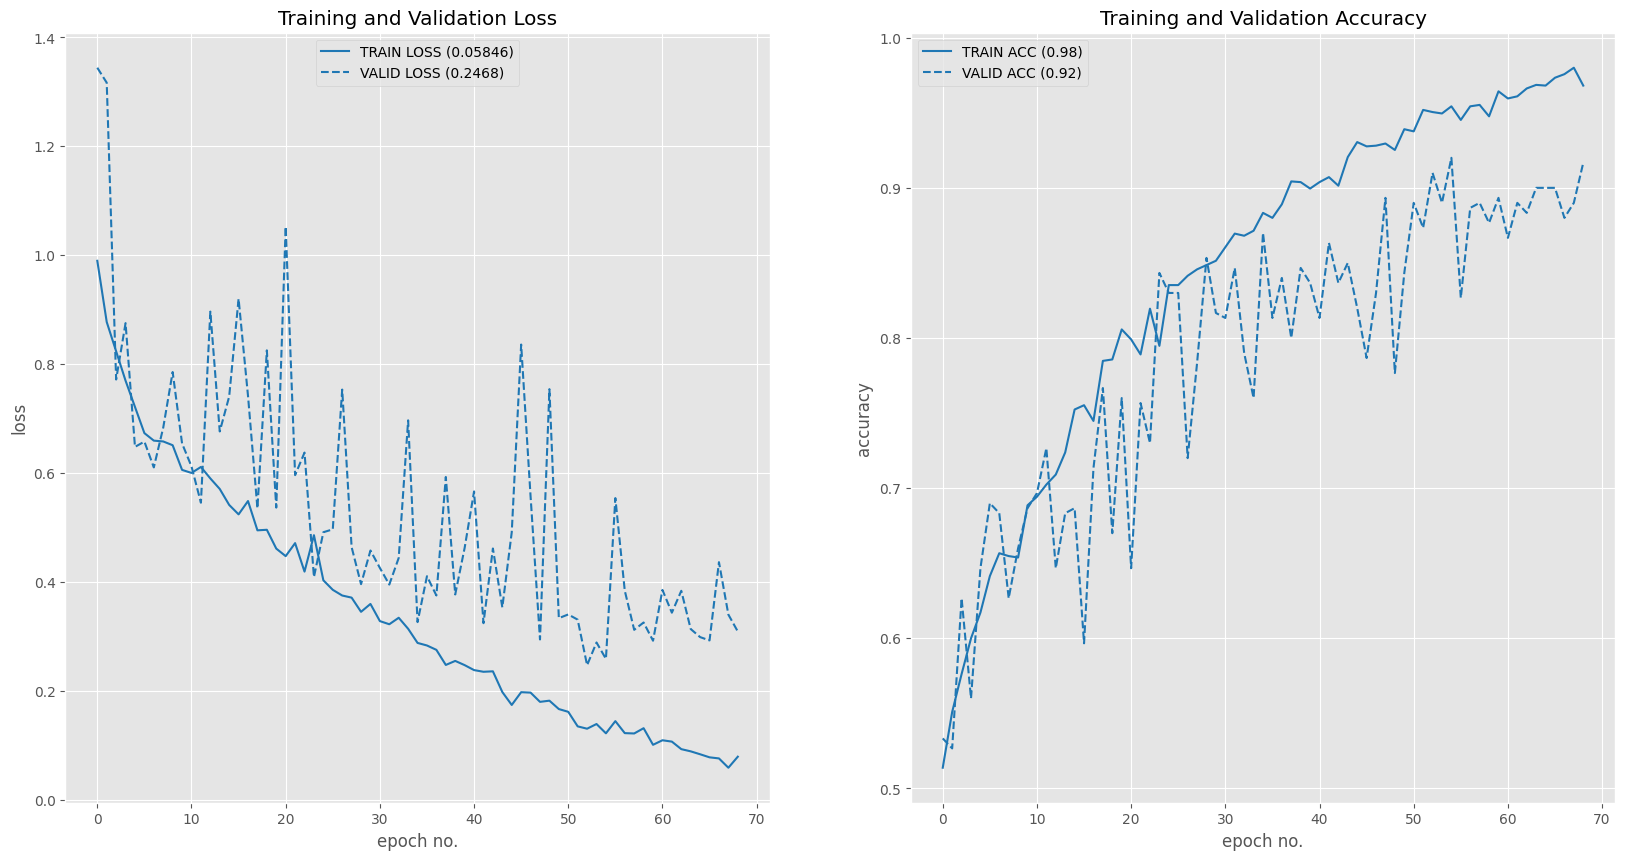

In [21]:
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

In [22]:
def prediction(model, device, batch_input):
    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax.
    prob = F.softmax(output, dim=1)

    # Get the max probability.
    pred_prob = prob.data.max(dim=1)[0]

    # Get the index of the max probability.
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [ ]:
def get_sample_prediction(model, data_root, img_size, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    model.eval()
    model.to(device)
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))
    data_len = valid_dataset.__len__()
    interval = int(data_len / batch_size)
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = valid_dataset_trans.__getitem__(index)
        img, _ = valid_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()

    for i, target in enumerate(targets):
        plt.subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[cls[i]]}({prob[i]:.2}), T:{valid_dataset.classes[targets[i]]}")
    plt.show()

    return

<ipython-input-13-4bb1e7806922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


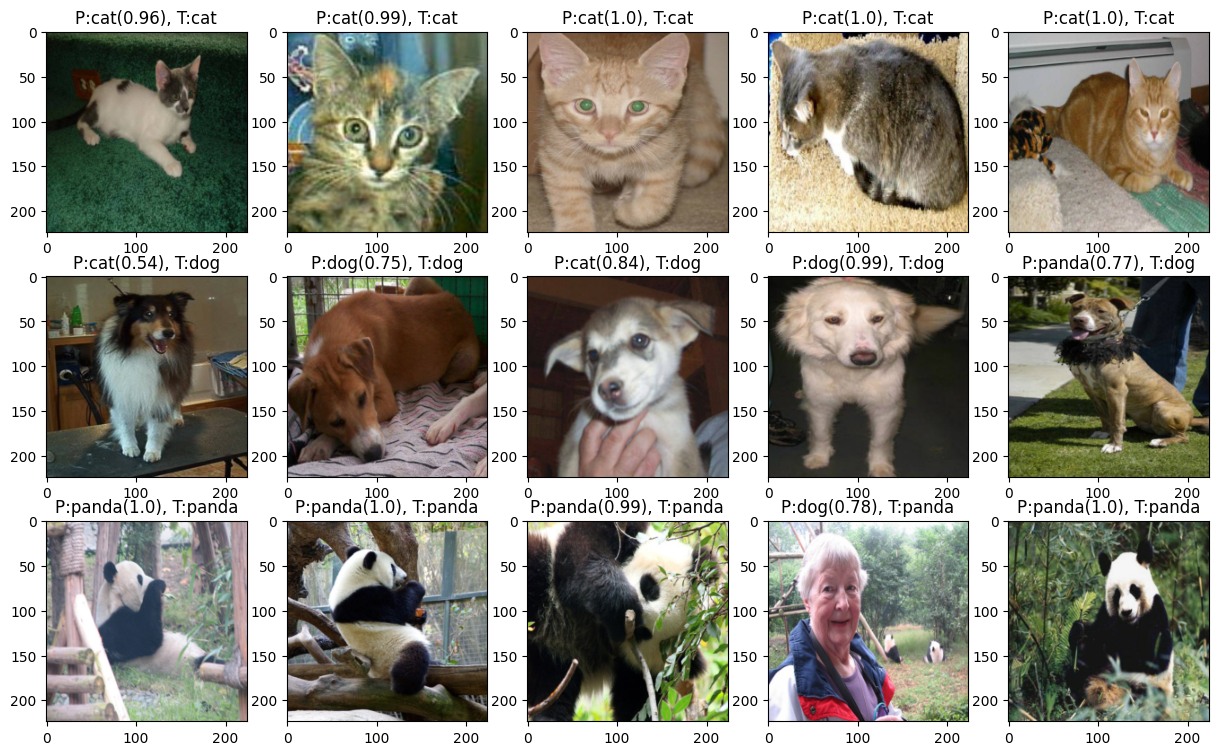

In [ ]:
trained_model = MyModel()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_model_name
)
train_data_path = os.path.join(training_config.data_root, "Train")
valid_data_path = os.path.join(training_config.data_root, "Valid")
mean, std = get_mean_std(train_data_path, img_size=training_config.img_size)
get_sample_prediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

<ipython-input-13-4bb1e7806922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


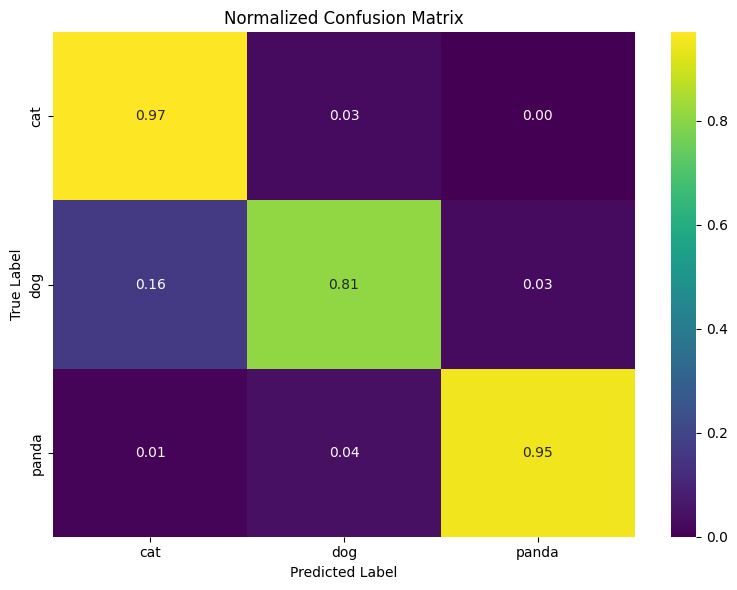

In [ ]:


def generate_confusion_matrix(NNModel, test_loader, class_names):
    NNModel.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(next(NNModel.parameters()).device)
            labels = labels.to(images.device)

            outputs = NNModel(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="viridis", xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title("Normalized Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_model_name
)
train_loader, valid_loader = get_data(
        batch_size=training_config.batch_size,
        data_root=training_config.data_root,
        img_size=training_config.img_size,
        num_workers=training_config.num_workers,
        data_augmentation=False,
    )
class_names = ["cat", "dog", "panda"]
generate_confusion_matrix(trained_model, valid_loader, class_names)

In [ ]:

class FlatFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [f for f in os.listdir(root) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx]  # (image tensor, filename)

# Function to prepare test data
def get_data_test(batch_size, data_root, img_size=(224, 224), num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, "Train")
    test_data_path = os.path.join(data_root, "Test")
    mean, std = get_mean_std(data_root=train_data_path, img_size=img_size, num_workers=num_workers)
    test_transforms = image_common_transforms(img_size, mean, std)
    test_dataset = FlatFolderDataset(test_data_path, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return test_loader

# Prediction function
from typing import List, Tuple

def delete_CSV_files():
    csv_files = glob.glob("/kaggle/working/*.csv")
    for file_path in csv_files:
        os.remove(file_path)

def Predict_Image_Label(NNModel, test_loader) -> pd.DataFrame:
    NNModel.eval()
    results = []

    # Label mapping
    label_map = {0: "cat", 1: "dog", 2: "panda"}

    with torch.no_grad():
        for images, image_ids in test_loader:
            images = images.to(next(NNModel.parameters()).device)
            outputs = NNModel(images)
            _, predicted = torch.max(outputs, 1)

            for img_id, pred in zip(image_ids, predicted):
                label_name = label_map.get(pred.item(), "unknown")
                results.append((img_id, label_name))

    # Convert to DataFrame matching your format
    df_results = pd.DataFrame(results, columns=["ID", "CLASS"])

    # Sort by filename (ID)
    df_results = df_results.sort_values(by="ID").reset_index(drop=True)

    return df_results

In [ ]:
test_loader = get_data_test(16, TrainingConfig.data_root)
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_model_name
)

df_predictions_sorted = Predict_Image_Label(trained_model, test_loader)
delete_CSV_files()
df_predictions_sorted.to_csv("Final_TestPredictions_Sorted.csv", index=False)

mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


<ipython-input-13-4bb1e7806922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


# <font style="color:red">Step 7. Generate Submission File [10 Points]</font>


**TASK**

1. Generate predictions on the test set.
2. Create a submission `.csv` file.
3. Upload the `.csv` file on Kaggle.


**REFERENCE**
1. **`test.csv`** -  This CSV file contains image IDs for the test set. Read this CSV file to generate predictions for each test image.

2. **`sample_submission.csv`** - Refer to this file to understand the structure of the csv file to be submitted. The sample_submission file is only to be used as reference. <br>
It contains columns:
    1. **`ID`**: same as the test.csv file
    2. **`CLASS`**: which contains random predictions




**<font style="color:red">Use the same column names that are given in the`sample_submission.csv` file.</font>**


## <font style="color:red">Step 8. Kaggle Submission Score [40 Points]</font>

**For full points, you need to achieve atleast `85%` accuracy on the Public Test leaderboard. If accuracy is less than `80%`, you gain no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, in order to get evaluated for this section.**

**Please share your profile link, user id and score achieved.**

```
URL:
Profile Name:
Points Scored:
```

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other.</font>**